# Chemical space of odor spectra: Predict and Compare

In [53]:
import sys
import os
curdir = os.path.abspath(os.path.curdir)
sys.path.append(os.path.join(curdir,'FUImaging'))
sys.path.append(os.path.join(curdir,'BootstrapPrediction'))

from regnmf import ImageAnalysisComponents as ia
from bootstrap_prediction import datastructures as ds
from bootstrap_prediction import bootstrap_predictor as bp
#reload(bp)

In [54]:
import glob, csv, json, os, pickle, copy
import matplotlib

import numpy as np
import pylab as plt

from scipy.spatial.distance import pdist, squareform
from collections import defaultdict
from sklearn.svm import SVR, NuSVR
from sklearn.ensemble import RandomForestRegressor 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.manifold import MDS
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from tqdm.autonotebook import tqdm

#### Set level of output messages

### Define Helper Functions

#### Functions to calculate EVA descriptor

In [55]:
def _gaussian(x, mu, sigma):
    return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x-mu)/float(sigma))**2)

def _sum_of_gaussians(x_range, positions, heights, sigma):
    assert len(positions) == len(heights)
    return [np.sum(heights * _gaussian(x, positions, sigma)) for x in x_range]

def calc_eva(spectra, spec_type='pure', kernel_width=10, bin_width=10, BFS_max=4000):
    """ sum of gaussians, sampled at regular intervals """
    #TODO: refactor with convolution for 10-fold speedup (at least)
    x_range = np.arange(0, BFS_max, bin_width)
    features, molnames = [], []
    for molid, spectrum in tqdm(spectra.items(), leave=False):
        # remove negative vibrations (result of imaginary frequencies)
        valid_freqs = spectrum['freq'][spectrum['freq'] > 0]
        intensities = spectrum[spec_type] if (spec_type != 'pure') else np.ones(len(spectrum['freq']))
        features.append(_sum_of_gaussians(x_range, spectrum['freq'], intensities, kernel_width))
        molnames.append(int(molid))
        
    feat_name = ['%sband%d_%d'%(spec_type,kernel_width,x) for x in x_range]
    
    features = ds.FeatureBank(feat_name, molnames, np.array(features))
    return features

#### Function to load csv descriptor file

required format: Each row contains feature values of a molecule. First row contains feature names. First column contains molecule id, second column gets skipped.

In [56]:
def load_feature(filename, filter_func=None, verbose=False):
    ''' read in feature from csv file, return FeatureBank instance'''
    descname = next(csv.reader(open(filename), delimiter=','))[2:]
    desc = np.genfromtxt(filename,  usecols=range(2,len(descname)+2), delimiter=',', skip_header=1)
    molid = np.genfromtxt(filename,  usecols=range(0,1), delimiter=',', skip_header=1, dtype=int)
    if filter_func:
        mask = np.sum(filter_func(desc),1) == 0
        desc = desc[mask]
        if verbose: print('removed mols ', [molid[i] for i in np.where(mask==False)[0]])
        molid = molid[mask]        
    return ds.FeatureBank(descname, molid, desc)

In [57]:
def condense_list_dict(dic, reducefct=np.mean):
    ''' apply reducefct to every value of dictionary'''
    reduced_dict = {}
    for k, v in dic.items():
        reduced_dict[k] = reducefct(v)
    return reduced_dict

#### Function to calculate distances in chemical space

Distance as overlap of support vector models

In [58]:
def sv_overlap(svm1, svm2, extension = 1):
    ''' calculates collective covered area for two support vector models'''
    ind_overlaps = []
    for ind1, sv1 in enumerate(svm1.support_vectors_):
        for ind2, sv2 in enumerate(svm2.support_vectors_):
            gamma = 1./svm1.support_vectors_.shape[1]          
            integral = np.exp(-0.5*gamma*extension*np.sum((sv1-sv2)**2))
            overlap = svm1.dual_coef_[:,ind1] * svm2.dual_coef_[:,ind2]*integral
            ind_overlaps.append(overlap)
    return np.sum(ind_overlaps)

Distance as weighted chemspace distance for all coactive molecules

In [59]:
def neighbourness(spec1, spec2, chemspace_dist):
    ''' weighted sum of chemspace distances of coactive molecules'''
    response_overlap = np.outer(spec1, spec2)
    response_overlap /= np.sum(response_overlap)
    neighbourness = np.sum(response_overlap*chemspace_dist)
    return neighbourness

#### Class to create scatterplots with interactive labelling

In [60]:
class AnnotationAxes:
    def __init__(self, ax):
        self.ax = ax
        self.labels = {}
        ax.get_figure().canvas.mpl_connect('pick_event', self.onpick)
        
    def onpick(self, event):
        self.ax.text(event.mouseevent.xdata, event.mouseevent.ydata, self.labels[event.artist])
       
        plt.draw()
        
    def scatter(self, x, y, annotation, **kwargs):
        for xval, yval, text in zip(x,y,annotation):
            handle = ax.scatter(xval, yval, picker=True, **kwargs)
            self.labels[handle] = text

## Read in Feature and Data

#### Specify parameter

In [61]:
#basepath = os.path.join('/home/jan/Dokumente/MOBData')
basepath = os.path.realpath(os.path.join(os.path.pardir, 'glomcentric_data'))
descriptorpath = os.path.join(basepath, 'ChemBase', 'odors_dez2013')
vibpath = os.path.join(basepath, 'ChemBase', 'odors_dez2013', 'Vib')
fullMOR182spec_file = os.path.join(basepath, 'DataDicts', 'MOR18-2spec.json')
cas2molid_file = os.path.join(basepath, 'ChemBase','odors_dez2013','cas2molid.csv')
cas2name_file = os.path.join(basepath, 'DataDicts', 'Name2MomCas.tab')
savepath = os.path.join(basepath, 'Vis', 'ChemSpace')
bg_path = os.path.join(basepath, 'MOBconverted')
fingerprinted_specfile = os.path.join(basepath, 'DataDicts', 
                                      #'spectra_correlation_average_nnmf_150_sm2_convex_sp*_ios_meas', 'ts')
                                      'spectra_correlation_average_nnmf_150_sm2_convex_sp__ios_meas', 'ts')              

#### Create mapping CAS to molecule ID

If CAS is ambiguous (enatiomeres), only one instance is picked

In [62]:
cas2molid = {l[0]:l[1] for l in csv.reader(open(cas2molid_file))}
cas2name = {l[0]:l[1] for l in csv.reader(open(cas2name_file),  delimiter='\t')}
molid2name = {v:cas2name[k] for k,v in cas2molid.items() if k in cas2name}

### Load complete feature pickle (skip the following steps)

In [63]:
featurespaces = pickle.load(open(os.path.join(basepath, 'DataDicts','fspaces.pik'),'rb'),encoding='latin1')

### eDragon Features

read in all eDragon features. Exclude molecules with errors (feature value = -999). Skip Features in list 'skip' (as for those too many molecules exibit errors)

In [64]:
featurespaces = {}
skip = ['INFORMATION_INDICES']
filter_func = lambda x: np.logical_or(np.isnan(x), x==-999)

all_featgroups = {}
filenames = glob.glob(os.path.join(descriptorpath, 'eDragon', '*.csv'))
for filename in filenames:
    name = os.path.basename(filename).split('.')[0]    
    if name in skip:
        continue
    feat = load_feature(filename, filter_func)
    all_featgroups[name] = feat
featurespaces.update(all_featgroups)
featurespaces['edragon_all'] = ds.combine_features(all_featgroups.values())

### Haddad, Saito and simple IJC features

In [65]:
featurespaces['haddad'] = load_feature(os.path.join(descriptorpath, 'haddad_desc.csv'), filter_func)
featurespaces['saito'] = load_feature(os.path.join(descriptorpath, 'saito_desc.csv'), filter_func)
featurespaces['ijc'] = load_feature(os.path.join(descriptorpath, 'ijc_shape.csv'), filter_func)

### EVA feature variants

create EVA features (and those scaled by ir respectivly raman intensity) for different kernel widths. Sampling steps are choosen equal to kernel width. 

In [66]:
import time
kernel_widths = [1, 5, 10, 20, 50, 100, 200] 
vib = pickle.load(open(os.path.join(vibpath, 'freq.pckl'),'rb'), encoding='latin1')
tic = time.time()
for k in tqdm(kernel_widths):
    eva = calc_eva(vib, bin_width=k, kernel_width=k)
    ir = calc_eva(vib, 'ir', bin_width=k, kernel_width=k)
    raman = calc_eva(vib, 'raman', bin_width=k, kernel_width=k)
    featurespaces['eva%03d'%k]=eva
    featurespaces['ir%03d'%k]=ir
    featurespaces['raman%03d'%k]=raman
    toc = time.time()
    print("EVA {} took {:.1f} s".format(k, toc-tic))
    tic = toc

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

EVA 1 took 155.0 s
EVA 5 took 31.1 s
EVA 10 took 15.6 s
EVA 20 took 8.3 s
EVA 50 took 3.3 s
EVA 100 took 1.7 s
EVA 200 took 1.0 s


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

hierachical combine kernel widths

In [67]:
combi = [10, 20, 50, 100, 200]

featurespaces['eva_hcombi'] = ds.combine_features([featurespaces['eva%03d'%k] for k in combi])
featurespaces['ir_hcombi'] = ds.combine_features([featurespaces['ir%03d'%k] for k in combi])
featurespaces['raman_hcombi'] = ds.combine_features([featurespaces['raman%03d'%k] for k in combi])

featurespaces['eva_all'] = ds.combine_features([featurespaces['eva%03d'%k] for k in [1,5,10,20,50,100,200]])
featurespaces['ir_all'] = ds.combine_features([featurespaces['ir%03d'%k] for k in [1,5,10,20,50,100,200]])
featurespaces['raman_all'] = ds.combine_features([featurespaces['raman%03d'%k] for k in [1,5,10,20,50,100,200]])

create featureset combinations

In [68]:
combi_feat = {
    #'all': ds.combine_features([featurespaces[name] for name in ['edragon_all', 'eva_hcombi', 'ir_hcombi', 'raman_hcombi']]),
    'edragon-ircombi': ds.combine_features([featurespaces[name] for name in ['edragon_all', 'ir_hcombi']]),
    'edragon-evacombi': ds.combine_features([featurespaces[name] for name in ['edragon_all', 'eva_hcombi']]),
    'edragon-eva10': ds.combine_features([featurespaces[name] for name in ['edragon_all', 'eva010']]),
    'edragon-eva1': ds.combine_features([featurespaces[name] for name in ['edragon_all', 'eva001']]),
    'edragon-eva5': ds.combine_features([featurespaces[name] for name in ['edragon_all', 'eva005']]),
    'edragon-ir10': ds.combine_features([featurespaces[name] for name in ['edragon_all', 'ir010']]),
    }
featurespaces.update(combi_feat)

#### Save all features

In [69]:
save = True
if save: 
    pickle.dump(featurespaces, open(os.path.join(basepath, 'DataDicts','fspaces.pik'),'wb'))

### Full MOR18-2 spectrum

In [70]:
method = 'nnmf_200_sm2_convex_negTimelowSP_sp*_ios_measnormed'
aggregate = np.mean

spec = json.load(open(fullMOR182spec_file))
mor182_spec_temp = condense_list_dict(spec[method], aggregate)
mor182_spec = {}
for k, v in mor182_spec_temp.items():
    k = k.strip()
    if k in cas2molid:
        mor182_spec[int(cas2molid[k])]= v
    elif len(k.split('_')) == 1:
        print("WARNING:no molid found for %s"%k)
        #note: mols like EA - GEO don't have a structure so not an issue if they don't show up
    else:
        #print('DEBUG: no molid found for %s'%k)
        pass

### Fingerprinted Spectra

Load fingerprinted spectra and convert to dictionary

In [71]:
fp_spec = ia.TimeSeries()
fp_spec.load(fingerprinted_specfile)
spec_dict = defaultdict(dict)
for clust_id, clust in enumerate(fp_spec.label_objects):
    for v, k in zip(fp_spec._series[:,clust_id], fp_spec.label_stimuli):
        k = k.strip()
        if k in cas2molid:
            spec_dict[clust][int(cas2molid[k])]=v
        else:
            print('INFO: no molid found for %s'%k)   

## Prediction Models

### Show difference in featurespace between ligands and nonligands for MOR18-2

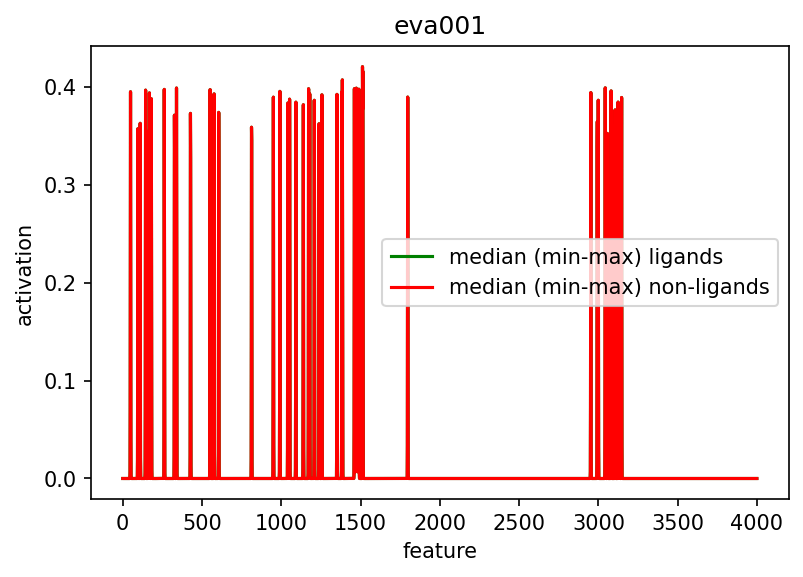

In [72]:
what = 'eva001'
zscore = False

mols = list(mor182_spec.keys())
ligands = [mols[i] for i in np.argsort(mor182_spec.values())[-10:]]
non_ligands = [mols[i] for i in np.argsort(mor182_spec.values())[:150]]
feat = copy.copy(featurespaces[what])
if zscore: feat.zscore()

ligand_vib = np.percentile(feat.data[[feat.obj_name.index(i) for i in ligands if i in feat.obj_name]],
                           [0,25,50,75,100], axis=0)
nonligand_vib = np.percentile(feat.data[[feat.obj_name.index(i) for i in non_ligands if i in feat.obj_name]],
                           [0,25,50,75,100], axis=0)

# plot
plt.plot(ligand_vib[2], 'g', label='median (min-max) ligands')
plt.fill_between(range(feat.data.shape[1]), ligand_vib[0], ligand_vib[-1], alpha=0.2, color='g')
plt.plot(nonligand_vib[2], 'r', label='median (min-max) non-ligands')
plt.fill_between(range(feat.data.shape[1]), nonligand_vib[0], nonligand_vib[-1], alpha=0.2, color='r')
plt.ylabel('activation')
plt.xlabel('feature')
plt.title(what)
plt.legend()
plt.show()

### Single Feature Relevance

#### Define Pyramid regression model

In [73]:
class PyramidRegression():

    def __init__(self):
        self.zenith = None
        self.ir1 = None
        self.ir2 = None
        
    def fit(self,x,y):

        ir1 = extIsotonicRegression()
        ir2 = extIsotonicRegression(increasing=False)
        
        order = np.argsort(x)
        x = x[order]
        y = y[order]
        se_list = []     
        se_list.append(np.sum((y-ir1.fit_transform(x,y))**2))
        for i in range(1,len(x)-1):
            y1 = ir1.fit_transform(x[:i],y[:i])
            y2 = ir2.fit_transform(x[i:],y[i:])
            se_list.append(np.sum((y[:i]-y1)**2)+np.sum((y[i:]-y2)**2))
        se_list.append(np.sum((y-ir2.fit_transform(x,y))**2))
        self.turnpoint = np.argmin(se_list)
        self.zenith = x[self.turnpoint]
        self.X_ = x
        # refit with best parameter
        yhat1, yhat2 = np.array([]), np.array([])
        if self.turnpoint>0:
            self.ir1 = extIsotonicRegression()
            if self.turnpoint==len(x):
                yhat1 = self.ir1.fit_transform(x,y)
            else:
                yhat1 = self.ir1.fit_transform(x[:self.turnpoint],y[:self.turnpoint])
        if self.turnpoint<len(x):
            self.ir2 = extIsotonicRegression(increasing=False)
            yhat2 = self.ir2.fit_transform(x[self.turnpoint:],y[self.turnpoint:])
        self.r2 = r2_score(y, np.hstack([yhat1, yhat2]))

     
    def transform(self,x):
        out = np.zeros(x.shape)
        mask_raise = x<self.zenith
        mask_fall = x>=self.zenith              
        if np.sum(mask_raise)>0:
            out[mask_raise] = self.ir1.transform(x[mask_raise])
        if np.sum(mask_fall)>0:
            out[mask_fall] = self.ir2.transform(x[mask_fall])
        return out
    
    def predict(self, x):
        return self.transform(x)

class extIsotonicRegression(IsotonicRegression):
    
    def __init__(self, **kwargs):
        super(extIsotonicRegression, self).__init__(**kwargs)
        
    def transform(self, x):
        xtemp =  x.copy()
        xmin,xmax = self.X_min_, self.X_max_
        xtemp[xtemp<xmin]=xmin
        xtemp[xtemp>xmax]=xmax
        return super(extIsotonicRegression, self).transform(xtemp)
    
    def predict(self, x):
        return self.transform(x)

# Feature selection score functions
def pyramid_score(X,y):
    r2 = []
    for x in X.T:
        py_reg = PyramidRegression()
        py_reg.fit(x+np.random.randn(len(x))*1E-7, y)
        r2.append(py_reg.r2) 
    return np.array(r2), None

def myfclassify(X,y, thres=0.5):
    return f_classif((X>thres).astype('int'), y)

#### Result collectors

In [74]:
trainsets = {}
r2 = {}

#### Evaluate monotonic regression models (linear, isotonic)

In [75]:
r2['monoincrease'] = defaultdict(list)
r2['monodecrease'] = defaultdict(list)
r2['linear'] = defaultdict(list)
keys = ['edragon_all', 'eva_all', 'ir_all', 'raman_all', 'ijc']
for k in tqdm(keys):
    feature = copy.deepcopy(featurespaces[k])
    trainsets[k] = ds.TrainData(mor182_spec, feature)
    y = trainsets[k].targets
    for i, single_feat in enumerate(tqdm(trainsets[k].features.T,leave=False)):
        x = single_feat.copy()+np.random.randn(len(single_feat))*1E-5
        ir_reg = IsotonicRegression()
        yhat = ir_reg.fit_transform(x, y)
        r2['monoincrease'][k].append(r2_score(y, yhat))
        
        ir_reg = IsotonicRegression(increasing=False)
        yhat = ir_reg.fit_transform(x, y)
        r2['monodecrease'][k].append(r2_score(y, yhat))
        
        x = x.reshape((-1,1))
        lin_reg = LinearRegression()
        lin_reg.fit(x, y)
        yhat = lin_reg.predict(x)
        r2['linear'][k].append(r2_score(y, yhat))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/5540 [00:00<?, ?it/s]

  0%|          | 0/5540 [00:00<?, ?it/s]

  0%|          | 0/5540 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

#### Evaluate pyramid regression models

In [76]:
keys = ['edragon_all', 'ijc', 'eva_all']

r2['pyramid'] = {}
for k in tqdm(keys):
    r2['pyramid'][k] = []
    feature = copy.deepcopy(featurespaces[k])
    trainsets[k] = ds.TrainData(mor182_spec, feature)
    y = trainsets[k].targets
    for i, single_feat in enumerate(tqdm(trainsets[k].features.T, leave=False)):
        x = single_feat.copy()+np.random.randn(len(single_feat))*1E-5
        py_reg = PyramidRegression()
        py_reg.fit(x, y)
        r2['pyramid'][k].append(py_reg.r2)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5540 [00:00<?, ?it/s]

#### Print best r2 score for different featurespaces

In [77]:
for m in ['linear', 'monoincrease', 'monodecrease', 'pyramid']: 
    print('========== %s =========='%m)
    for k in ['ijc', 'edragon_all', 'eva_all']:
        i = np.argmax(r2[m][k])
        print(k, [trainsets[k].feat_name[i]], r2[m][k][i])

========== linear ==========
ijc ['CAtoms'] 0.0495134134704861
edragon_all ['BEHp1'] 0.13609801591807302
eva_all ['pureband1_1812'] 0.2028572716745718
========== monoincrease ==========
ijc ['VP ACD mmHG25'] 0.22536603707888192
edragon_all ['E1u'] 0.23658055804962796
eva_all ['pureband1_1813'] 0.30406363793500846
========== monodecrease ==========
ijc ['CAtoms'] 0.11719678937912537
edragon_all ['ATS2p'] 0.2866185210969425
eva_all ['pureband20_740'] 0.28524568462704314
========== pyramid ==========
ijc ['VP ACD mmHG25'] 0.2962872742421043
edragon_all ['ATS2p'] 0.4139811149932241
eva_all ['pureband5_1820'] 0.5027501235086239


#### SVR with feature selection

In [78]:
featnum = [1,2,4,8,16, 32,64,128, 256, 512]
k = 'edragon-eva5'
selection_func = myfclassify #pyramid_score

feature = copy.deepcopy(featurespaces[k])
feature.zscore()
trainset = ds.TrainData(mor182_spec, feature)

for num in featnum:    
    estimator_class = bp.BootstrapRegressor
    estimator_param ={'regressor':bp.FilteredRegressor, 
                      'reg_param':{'regressor': NuSVR, 'reg_param':{'C':0.9},
                                   'filtering':SelectKBest, 'filt_param':{'score_func':selection_func, 'k':num}}, 
                      'n_member':20, 'strat_thres':0.5}
    estimator = estimator_class(**estimator_param) 
    estimator.fit(trainset.features, trainset.targets)
    t1 = estimator.oob_score_single
    t2 = estimator.oob_score_
    print(f'{num} {estimator.oob_score_single}, {estimator.oob_score_}')

/home/sam/anaconda3/envs/glomcentric_code/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in true_divide
  msw = sswn / float(dfwn)
/home/sam/anaconda3/envs/glomcentric_code/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [   0    1    2 ... 2397 2398 2399] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/sam/anaconda3/envs/glomcentric_code/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/home/sam/anaconda3/envs/glomcentric_code/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/sam/anaconda3/envs/glomcentric_code/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114

1 -0.03771884922761681, -0.029407660712661654
2 -0.036136756752739974, -0.03153797613909881
4 -0.021248609745727842, -0.017840876413984796
8 -0.013498657831408911, -0.014701460774815933
16 -0.01694692227176997, -0.016558290566228706
32 -0.046524370859916564, -0.035808098700775615
64 -0.052256680089235896, -0.013138926203492884
128 0.01976252062274153, 0.06737309403931979
256 0.037567463368916365, 0.11195386387940953
512 0.2284244536264297, 0.2783436320509224


### MOR18-2 prediction for different Featurespaces

#### Fit SVR models on bootstrap samples for validation

In [79]:
# remove some featspace to save memory
keys = list(featurespaces.keys())
[featurespaces.pop(k) for k in keys if (('raman' in k) or ('ir' in k))]

In [80]:
remove = [140, 1016, 92, 164, 1000, 239, 1012, 312] #molecules with no features in some featurespace
mor182_spec_clean = copy.deepcopy(mor182_spec)
[mor182_spec_clean.pop(i) for i in remove]
models_mor182 = {}

In [81]:
to_evaluate = featurespaces
estimator_class = bp.BootstrapRegressor
estimator_param ={'regressor': SVR, 'reg_param':{'C':5, 'epsilon':0.1}, 'n_member':50, 'strat_thres':2}

for ix, featspace in enumerate(to_evaluate):
    feature = copy.deepcopy(to_evaluate[featspace])
    feature.zscore()
    mytrain = ds.TrainData(mor182_spec, feature)
    estimator = estimator_class(**estimator_param) 
    estimator.fit(mytrain.features, mytrain.targets)
    models_mor182[featspace] = (estimator, mytrain)

#### Plot model performance of feature spaces

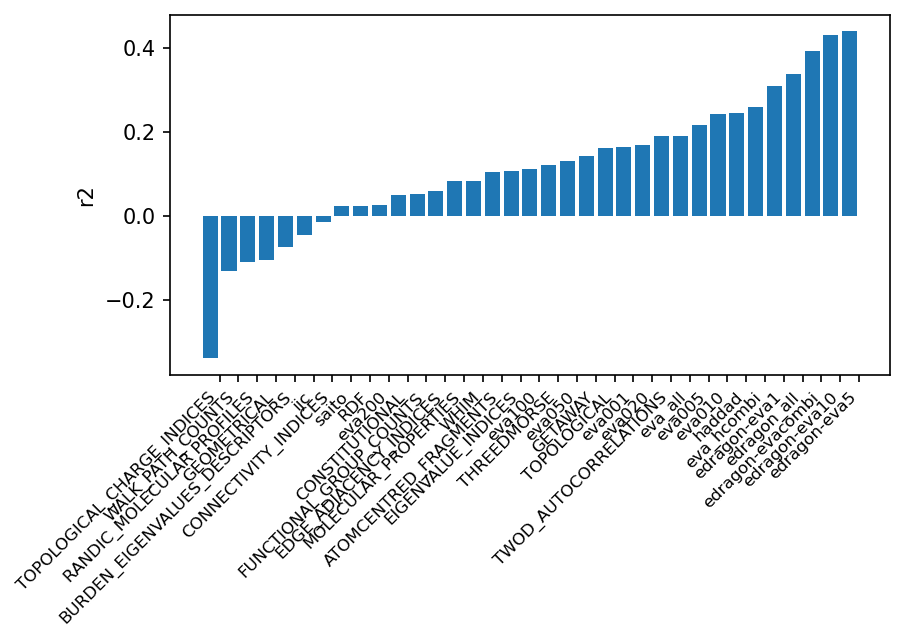

In [82]:
plt.rcParams['figure.dpi'] = 150
toplot = list(models_mor182.keys())
performance = np.array([models_mor182[k][0].oob_score_single for k in toplot])
order = np.argsort(performance)

fig = plt.figure()
ax = fig.add_axes([0.15,0.35,0.8,0.6])
x = np.arange(performance.size)
ax.bar(x, np.sort(performance))
ax.set_xticks(x+0.5)
ax.set_xticklabels([toplot[i] for i in order], rotation='45', ha='right', size=8)
ax.set_ylabel('r2')
plt.show()

#fig.savefig(os.path.join(savepath, 'featspac_performance.pdf'))

#### Bootstrap prediction vs. target plot 

Click on scatterpoints to display odor name

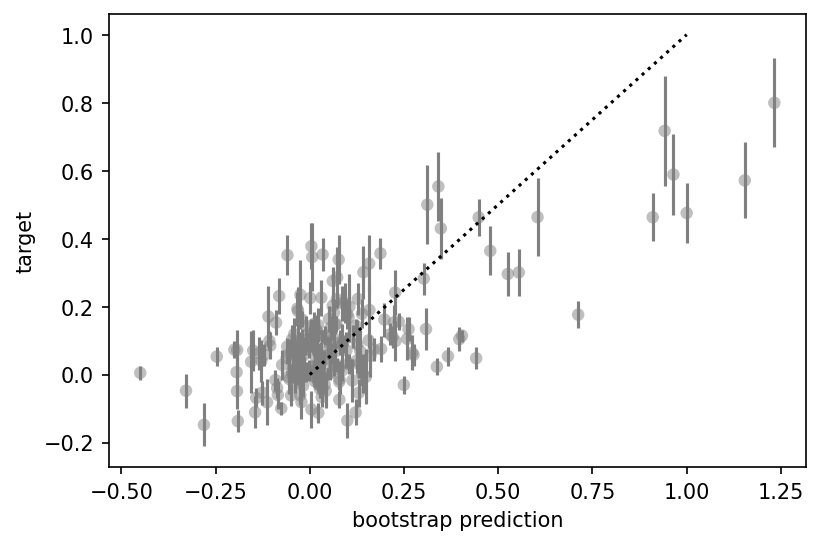

In [83]:
model, traindata = models_mor182['edragon-eva10']

fig = plt.figure()
ax = fig.add_subplot(111)
aax = AnnotationAxes(ax)

annotations = [molid2name[str(i)] if str(i) in molid2name else '' for i in traindata.obj_name]

std =  [np.std(model._pred_dict[mol]) for mol in model._train_targets.keys()]
aax.scatter(model._train_targets.values(), model.oob_prediction, 
            annotations, facecolors='0.5', alpha=0.5, edgecolors='none')
ax.errorbar(model._train_targets.values(), model.oob_prediction, yerr=std,
            fmt='none', ecolor='0.5')
ax.set_xlabel('bootstrap prediction')
ax.set_ylabel('target')

plt.plot([0,1], [0,1], 'k:')
plt.show()

### Prediction for fingerprinted spectra

#### Fit SVR models on bootstrap samples for validation

In [84]:
feat = copy.deepcopy(combi_feat['edragon-eva5'])
feat.zscore()
estimator_class = bp.BootstrapRegressor
estimator_param ={'regressor': NuSVR, 'reg_param':{'C':10}, 'n_member':50, 'strat_thres':2}

models_fingerprinted = {}

for clustid in spec_dict: 
    spec_data = spec_dict[clustid]
    mytrain = ds.TrainData(spec_data, feat)
    estimator = estimator_class(**estimator_param) 
    estimator.fit(mytrain.features, mytrain.targets)
    models_fingerprinted[clustid] = (estimator, mytrain)

#### Show prediction quality for different spectra

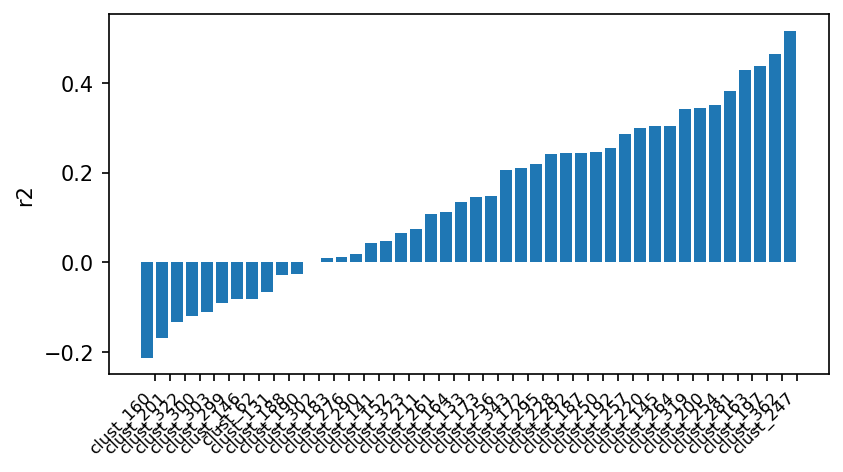

In [85]:
performance = np.array([i[0].oob_score_single for i in models_fingerprinted.values()])
order = np.argsort(performance)

fig = plt.figure()
ax = fig.add_axes([0.15,0.35,0.8,0.6])
x = np.arange(performance.size)
ax.bar(x, np.sort(performance))
ax.set_xticks(x+0.5)
ax.set_xticklabels([list(models_fingerprinted.keys())[i] for i in order], rotation='45', ha='right', size=8)
ax.set_ylabel('r2')
plt.show()

#### Bootstrap prediction vs. target plot 

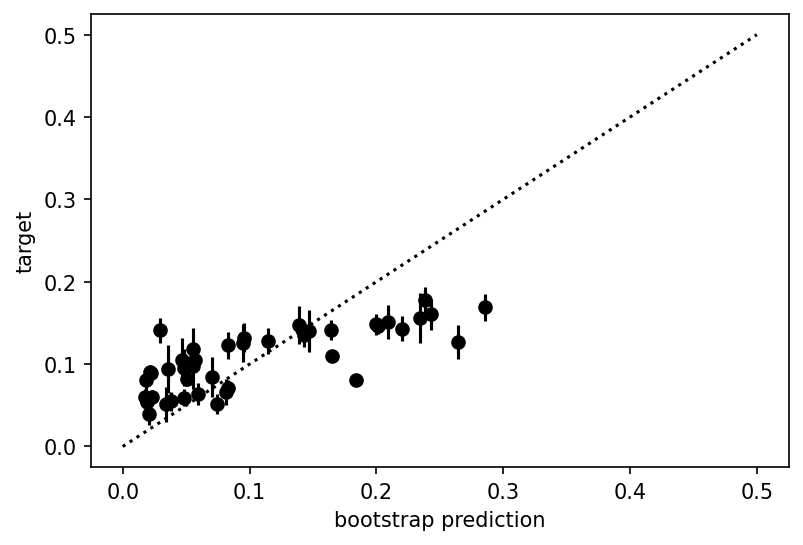

In [86]:
clustid = 'clust_362'
model, traindata = models_fingerprinted[clustid]

fig = plt.figure()
ax = fig.add_subplot(111)
aax = AnnotationAxes(ax)

annotations = [molid2name[str(i)] if str(i) in molid2name else '' for i in traindata.obj_name]
x = model._train_targets.values()
y = model.oob_prediction #odel.full_regressor.predict(traindata.features) #
std =  [np.std(model._pred_dict[mol]) for mol in model._train_targets.keys()]

aax.scatter(x, y, annotations, facecolors='k')
ax.errorbar(x, y, yerr=std, fmt='none', ecolor='k')
ax.set_xlabel('bootstrap prediction')
ax.set_ylabel('target')

plt.plot([0,0.5], [0,0.5], 'k:')
plt.show()

### Distance of MOR18-2 to other fingerprinted spectra

In [87]:
feat = copy.deepcopy(featurespaces['edragon-eva5'])
feat.zscore()

traindata = ds.TrainData(spec_dict['clust_200'], feat)
rbf_dist = pdist(traindata.features, 'euclidean') #lambda u,v: 1-np.exp(-((u-v)**2).sum()/traindata.features.shape[1]))

#### Calculate weighted distance of coactive molecules 

In [88]:
reference = 'clust_200'
rand = np.abs(np.random.randn(44)*1E-10)
spec1 = [spec_dict[reference][i] for i in traindata.obj_name]+rand

overlaps = {} 
for k  in spec_dict:
    spec2 = [spec_dict[k][i] for i in traindata.obj_name]+rand
    overlaps[k] = neighbourness(spec1, spec2, squareform(rbf_dist))
mycmap = plt.cm.RdYlGn_r
sortedval = np.sort(list(overlaps.values()))
distmin, distmax = sortedval[4], sortedval[-5]

#### or calculate overlap of SVR models

In [89]:
reference = 'clust_200'
svr1 = models_fingerprinted[reference][0].full_regressor

overlaps = {} 
for k, (model, traindata) in models_fingerprinted.items():
    overlaps[k] = sv_overlap(svr1, model.full_regressor, 1)
mycmap = plt.cm.RdYlGn
sortedval = np.sort(list(overlaps.values()))
distmin, distmax = sortedval[1], sortedval[-3]

### Visualization of chemical similarity

#### load bg images

In [90]:
animals = ['111210sph', '111221sph', '111222sph', '120107', '120119', '120121', '120125']
turn = ['111222sph', '120119', '120121'] #turn if left bulb
bg_list = [plt.imread(os.path.join(bg_path, measID, 'bg.png')) for measID in animals]
for ani in turn:
    bg_list[animals.index(ani)] = bg_list[animals.index(ani)][::-1]

#### plot chemical distance to MOR18-2

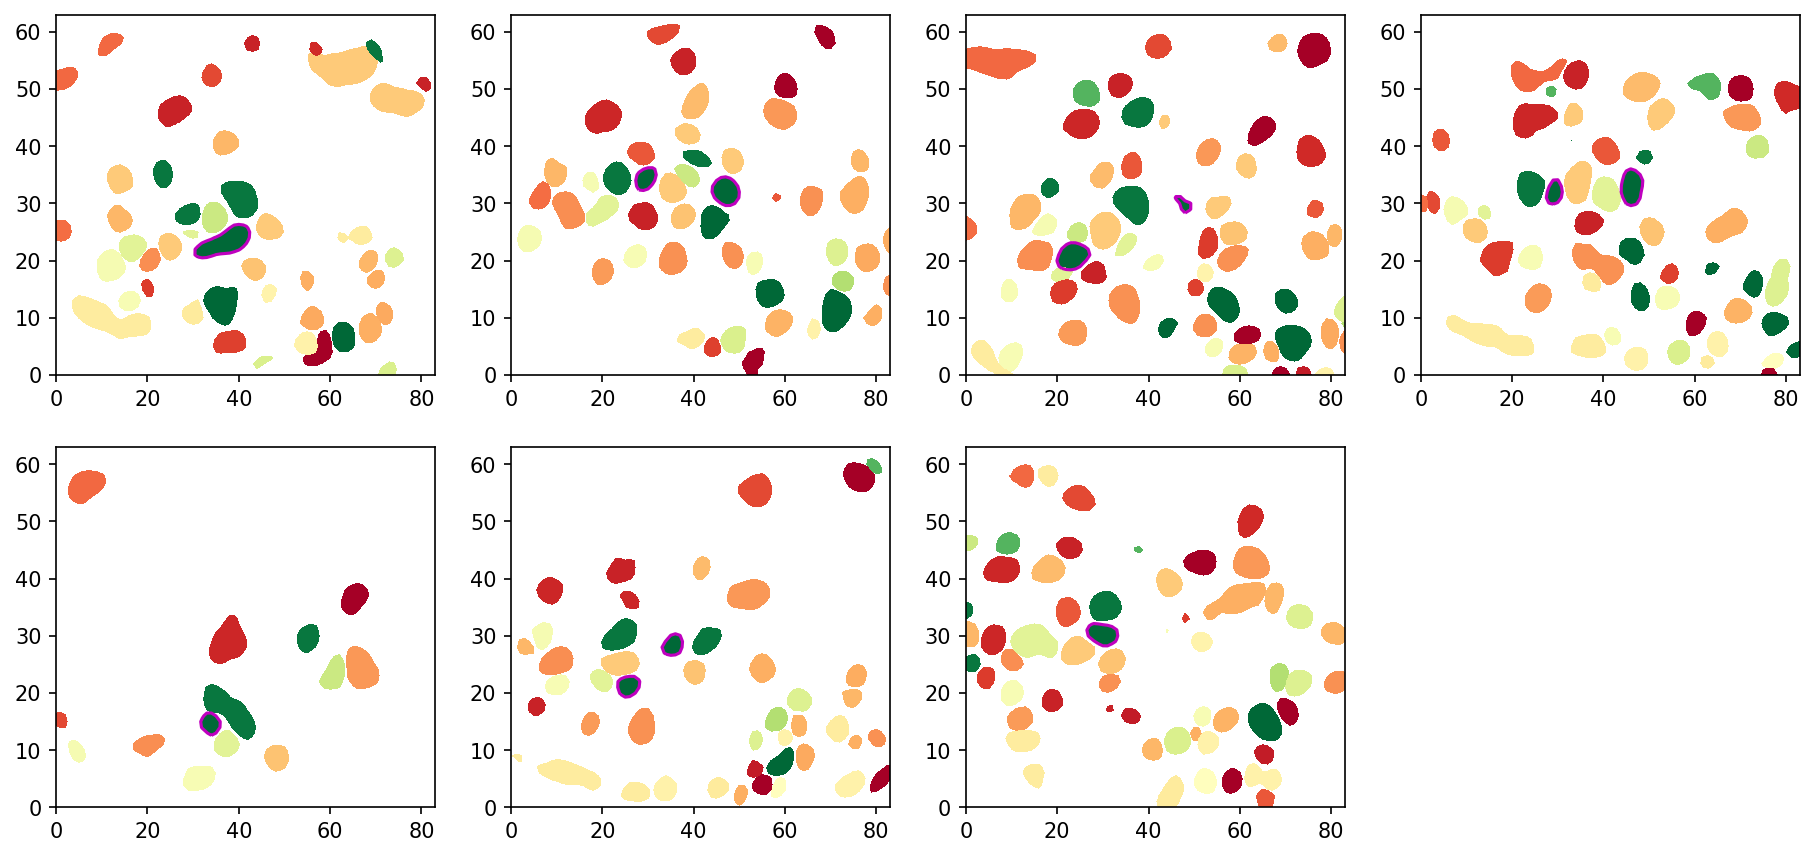

In [91]:
fig = plt.figure(figsize=(15,7))
axes= [fig.add_subplot(2,4,i+1) for i in range(7)]

'''
for i, ax in enumerate(axes):
    ax.imshow(bg_list[i], interpolation='none', cmap=plt.cm.bone, extent=[0,84,64,0])
    ax.set_axis_off()
'''

for clust_num, clust in enumerate(fp_spec.label_objects):
    dist = (overlaps[clust]-distmin)/(distmax-distmin)
    for ind, base in enumerate(fp_spec.base.objects_sample(clust_num)):
        axes[ind].contourf(base, [0.5,2], colors=[mycmap(dist)])
for ind, base in enumerate(fp_spec.base.objects_sample(fp_spec.label_objects.index(reference))):
    axes[ind].contour(base, [0.5], colors=['m'])
plt.show()

### Spectral embedding of receptive Fields in chemical Space

In [92]:
spt_nbor = ['clust_%d'%i for i in [200,250,211,172,300,264,257,292,261,131,146,62]]

In [93]:
feat = copy.deepcopy(featurespaces['edragon-eva5'])
feat.zscore()

traindata = ds.TrainData(spec_dict['clust_200'], feat)
rbf_dist = pdist(traindata.features, 'euclidean') #lambda u,v: 1-np.exp(-((u-v)**2).sum()/traindata.features.shape[1]))

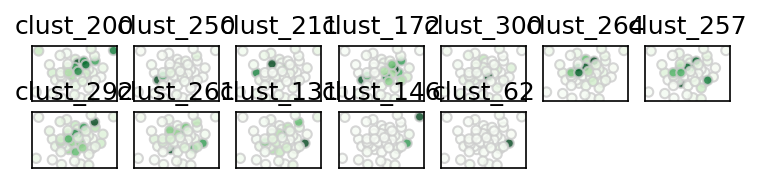

In [94]:
embedding = MDS(dissimilarity='precomputed', n_components=2, random_state=1)
out = embedding.fit_transform(squareform(rbf_dist))

fig = plt.figure()
for ind, k in  enumerate(spt_nbor): #enumerate(spec_dict):
    ax = fig.add_subplot(7, 7, ind+1)
    data = spec_dict[k]
    norm = np.max(list(data.values()))
    ax.scatter(out[:,0], out[:,1], s=20, linewidths=1,
                facecolor= [plt.cm.Greens(data[i]/norm) for i in traindata.obj_name],
                edgecolor= '0.8', alpha=0.8)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(k)
plt.show()